# <font color='blue'>**Байесовский подбор гиперпараметров**</font>

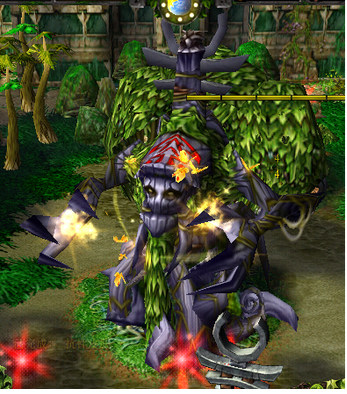

Сегодня мы вырастим дерево. Главное - подобрать оптимальные гиперпараметры

# <font color='green'>0. Импорт необходимых модулей</font>  

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

State для всех моделей

In [ ]:
state = 42

# <font color='green'>1. Загрузим наш игрушечный датасет</font>  

Попробуем предсказать кислотность вина. Подробнее:

https://scikit-learn.org/stable/datasets/toy_dataset.html

In [ ]:
from sklearn.datasets import load_wine

Загружаем датасет

In [ ]:
data = load_wine()

Находим в нём фичи и таргет

In [ ]:
X, y = data.data, data.target
X.shape, y.shape

((178, 13), (178,))

Нам нужно предсказать один из трёх классов вина

In [ ]:
print(np.unique(y, return_counts=True))

(array([0, 1, 2]), array([59, 71, 48]))


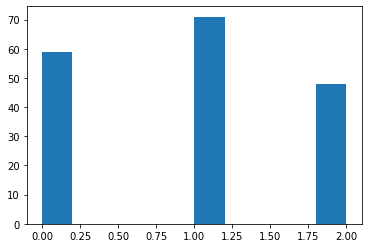

In [ ]:
plt.hist(y)
plt.show()

Поделим данные на train и test

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

# <font color='green'>2. GridSearch</font>  

Импортируем деревья

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import GridSearchCV



Дока (https://scikit-learn.org/stable/modules/ensemble.html#forests-of-randomized-trees) подсказывает нам, что самые важные параметры: 

* число деревьев (n_estimators)
* сколько фичей рассмотреть для лучшего 
разбиения (max_features)


In [ ]:
param_grid = {
    'max_depth': [3, 5, 7],
    'max_features': ["auto", "sqrt", "log2"],
    'n_estimators': [100, 200, 300]
}

clf = RandomForestClassifier(random_state=state)

grid = GridSearchCV(clf, param_grid, cv=5, scoring='neg_log_loss')

In [ ]:
%%time
grid.fit(X_train, y_train)

CPU times: user 40 s, sys: 323 ms, total: 40.4 s
Wall time: 40.2 s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [3, 5, 7],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_log_loss')

In [ ]:
grid.best_params_

{'max_depth': 7, 'max_features': 'auto', 'n_estimators': 100}

In [ ]:
best_grid = RandomForestClassifier(**grid.best_params_, random_state=state)
best_grid.fit(X_train, y_train)
print(f"LogLoss for Grid Tree {log_loss(y_test, best_grid.predict_proba(X_test))}")

LogLoss for Grid Tree 0.11154540826065935


# <font color='green'>3. Байесовский подбор гиперпараметров</font>  

Воспользуемся библиотекой Optuna

https://optuna.readthedocs.io/en/latest/tutorial/index.html

Есть и другие библиотеки (например сравнение с HyperOpt дано в https://neptune.ai/blog/optuna-vs-hyperopt)

In [ ]:
pip install optuna

     |████████████████████████████████| 308 kB 4.9 MB/s 
     |████████████████████████████████| 210 kB 62.2 MB/s 
     |████████████████████████████████| 81 kB 8.1 MB/s 
     |████████████████████████████████| 78 kB 5.5 MB/s 
     |████████████████████████████████| 113 kB 64.0 MB/s 
     |████████████████████████████████| 49 kB 5.1 MB/s 
     |████████████████████████████████| 150 kB 61.1 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=cf7ca84b5c09681b209b787ebd06344ccff6672d7277f494aa7af42d44366347
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
import optuna

В Optuna все вычисления переносятся в **objective**, которая возвращает значение метрики

Ниже - пример как задавать *перебираемые параметры* (trial.suggest_int и т.д.)

In [ ]:
def objective(trial):
  # Categorical parameter
    max_features = trial.suggest_categorical("max_features", ["auto", "sqrt", "log2"])

    # Integer parameter
    max_depth = trial.suggest_int("max_depth", 3, 7, step=2)
    n_estimators = trial.suggest_int("n_estimators", 100, 300, step=100)

    clf = RandomForestClassifier(random_state=state,
                                 max_features = max_features,
                                 max_depth = max_depth,
                                 n_estimators = n_estimators)

    clf.fit(X_train, y_train)
    
    return log_loss(y_test, clf.predict_proba(X_test))

Создаётся **study** и затем **n_trials** производится оптимизация параметров

In [ ]:
%%time
study = optuna.create_study()
study.optimize(objective, n_trials=20)

[I 2022-04-09 14:49:09,387] A new study created in memory with name: no-name-25e89101-c7ad-4b63-9121-6993eaddf2ac
[I 2022-04-09 14:49:09,850] Trial 0 finished with value: 0.17770345471191967 and parameters: {'max_features': 'log2', 'max_depth': 3, 'n_estimators': 300}. Best is trial 0 with value: 0.17770345471191967.
[I 2022-04-09 14:49:10,016] Trial 1 finished with value: 0.11154540826065935 and parameters: {'max_features': 'log2', 'max_depth': 7, 'n_estimators': 100}. Best is trial 1 with value: 0.11154540826065935.
[I 2022-04-09 14:49:10,325] Trial 2 finished with value: 0.12026847720951267 and parameters: {'max_features': 'auto', 'max_depth': 5, 'n_estimators': 200}. Best is trial 1 with value: 0.11154540826065935.
[I 2022-04-09 14:49:10,486] Trial 3 finished with value: 0.11154540826065935 and parameters: {'max_features': 'log2', 'max_depth': 7, 'n_estimators': 100}. Best is trial 1 with value: 0.11154540826065935.
[I 2022-04-09 14:49:10,968] Trial 4 finished with value: 0.1777034

CPU times: user 5.57 s, sys: 54.3 ms, total: 5.63 s
Wall time: 5.63 s


Если мы захотим посмотреть на лучшую модель:

In [ ]:
print(study.best_trial.params)

{'max_features': 'log2', 'max_depth': 7, 'n_estimators': 100}


In [ ]:
best_opt = RandomForestClassifier(**study.best_trial.params, random_state=state)
best_opt.fit(X_train, y_train)
print(f"LogLoss for Grid Tree {log_loss(y_test, best_opt.predict_proba(X_test))}")

LogLoss for Grid Tree 0.11154540826065935


## <font color='green'>3.1 Визуализация в Optuna </font>  

In [ ]:
from optuna.visualization import plot_optimization_history

Можно посмотреть, как меняется скор со временем

In [ ]:
plot_optimization_history(study)

Какие параметры дают какой скор

In [ ]:
from optuna.visualization import plot_parallel_coordinate
plot_parallel_coordinate(study)

И какие фичи наиболее важные:

In [ ]:
optuna.visualization.plot_param_importances(
    study, target=lambda t: t.duration.total_seconds(), target_name="duration"
)